In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold

import statsmodels 
import statsmodels.api as sm
import matplotlib.pyplot as plt
    
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error

from functools import partial
from tqdm import tqdm
import datetime as dt
from dateutil.relativedelta import relativedelta

import itertools

In [2]:
pd.set_option('display.max_columns', None)
tqdm.pandas()

# Loading Data

In [3]:
df_train = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
df_revealed = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/revealed_test.csv')
df_test = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')

df_train['first_day_of_month'] = pd.to_datetime(df_train["first_day_of_month"])
df_revealed['first_day_of_month'] = pd.to_datetime(df_revealed["first_day_of_month"])
df_test['first_day_of_month'] = pd.to_datetime(df_test["first_day_of_month"])

df_census = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')

df_state_loc= pd.read_csv('/kaggle/input/latitude-and-longitude-of-states-in-the-us/states.csv',  usecols=['name','latitude','longitude'])
df_state_loc.rename(columns={'name':'state','latitude':'state_latitude','longitude':'state_longitude'}, inplace=True)

df_county_loc= pd.read_csv('/kaggle/input/uscensus2022116thcongressionaldistricts/2022_Gaz_counties_national.csv',skipinitialspace=True, usecols=['GEOID','INTPTLAT','INTPTLONG'])
df_county_loc.rename(columns={'GEOID':'cfips', 'INTPTLAT':'county_latitude','INTPTLONG':'county_longitude'}, inplace=True)

### Loading Extra Population Data 

In [4]:
COLS = ['GEO_ID','NAME','S0101_C01_026E']

df2017 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2017.S0101-Data.csv',usecols=COLS)
df2017 = df2017.iloc[1:]
df2017['S0101_C01_026E'] = df2017['S0101_C01_026E'].astype('int')
print( df2017.shape )

df2018 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2018.S0101-Data.csv',usecols=COLS)
df2018 = df2018.iloc[1:]
df2018['S0101_C01_026E'] = df2018['S0101_C01_026E'].astype('int')
print( df2018.shape )

df2019 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2019.S0101-Data.csv',usecols=COLS)
df2019 = df2019.iloc[1:]
df2019['S0101_C01_026E'] = df2019['S0101_C01_026E'].astype('int')
print( df2019.shape )

df2020 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2020.S0101-Data.csv',usecols=COLS)
df2020 = df2020.iloc[1:]
df2020['S0101_C01_026E'] = df2020['S0101_C01_026E'].astype('int')
print( df2020.shape )

df2021 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2021.S0101-Data.csv',usecols=COLS)
df2021 = df2021.iloc[1:]
df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype('int')
print( df2021.shape )

# adjust missing value for Valdez–Cordova Census Area, Alaska where is not valid anymore after 2019
df2020=df2020.append(df2019[df2019.GEO_ID=='0500000US02261'])
df2020.loc[df2020.GEO_ID=='0500000US02261','S0101_C01_026E']=df2020[df2020.GEO_ID.isin(['0500000US02063', '0500000US02066'])]['S0101_C01_026E'].sum()

df2021=df2021.append(df2019[df2019.GEO_ID=='0500000US02261'])
df2021.loc[df2021.GEO_ID=='0500000US02261','S0101_C01_026E']=df2021[df2021.GEO_ID.isin(['0500000US02063', '0500000US02066'])]['S0101_C01_026E'].sum()


pop_df_dic={2017:df2017,2018:df2018, 2019:df2019, 2020:df2020, 2021:df2021}

df2021.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(3220, 3)
(3220, 3)
(3220, 3)
(3221, 3)
(3221, 3)


,GEO_ID,NAME,S0101_C01_026E
1,0500000US01001,"Autauga County, Alabama",44438
2,0500000US01003,"Baldwin County, Alabama",178105
3,0500000US01005,"Barbour County, Alabama",19995
4,0500000US01007,"Bibb County, Alabama",17800
5,0500000US01009,"Blount County, Alabama",45201


In [5]:
df_census.set_index('cfips',inplace=True)
for y, df in pop_df_dic.items():
    print(f"{y} size:{df.shape}")
    df['cfips'] = df.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )    
    df.set_index(['cfips'], inplace=True)
    df_census[f'population_{y}']=df.S0101_C01_026E.astype('int')

df_census.reset_index(inplace=True)
df_census

2017 size:(3220, 3)
2018 size:(3220, 3)
2019 size:(3220, 3)
2020 size:(3222, 3)
2021 size:(3222, 3)


,cfips,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,population_2017,population_2018,population_2019,population_2020,population_2021
0,1001,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,41527,41831,42175,42496,44438
1,1003,74.5,78.1,81.8,85.1,87.9,20.4,20.7,21.0,20.2,20.6,3.2,3.4,3.7,3.4,3.5,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0,158361,162430,166595,171296,178105
2,1005,57.2,60.4,60.5,64.6,64.6,7.6,7.8,7.6,7.3,6.7,2.7,2.5,2.7,2.6,2.6,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0,20687,20346,20054,19804,19995
3,1007,62.0,66.1,69.2,76.1,74.6,8.1,7.6,6.5,7.4,7.9,1.0,1.4,1.5,1.6,1.1,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0,17852,17868,17862,17790,17800
4,1009,65.8,68.5,73.0,79.6,81.0,8.7,8.1,8.6,8.9,9.3,4.5,4.4,4.5,4.4,4.5,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0,44102,44177,44292,44383,45201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,82.2,82.4,84.0,86.7,88.4,15.3,15.2,14.8,13.7,12.4,5.0,5.3,4.7,5.2,5.5,0.6,0.6,1.0,0.9,1.0,71083,73008.0,74843,73384.0,76668.0,32571,32308,31974,32049,31514
3138,56039,83.5,85.9,87.1,89.1,90.5,37.7,37.8,38.9,37.2,38.3,10.8,11.2,11.8,11.4,11.1,0.7,1.2,1.4,1.5,2.0,80049,83831.0,84678,87053.0,94498.0,18488,18625,18842,19164,19169
3139,56041,83.8,88.2,89.5,91.4,90.6,11.9,10.5,11.1,12.6,12.3,2.9,3.1,2.9,2.9,2.9,1.2,1.2,1.4,1.7,0.9,54672,58235.0,63403,72458.0,75106.0,14614,14538,14506,14516,14641
3140,56043,76.4,78.3,78.2,82.8,85.4,15.4,15.0,15.4,15.0,17.2,2.3,1.4,1.6,2.2,1.0,1.3,1.0,0.9,0.9,1.1,51362,53426.0,54158,57306.0,62271.0,6223,6187,6049,6045,6000


In [6]:
adult2020 = df2020.S0101_C01_026E#.to_dict()
adult2021 = df2021.S0101_C01_026E#.to_dict()

population_adjustment=adult2020/adult2021
population_adjustment=population_adjustment.to_dict()


In [7]:
df_train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [8]:
(df_train.cfips.nunique(),df_test.cfips.nunique())

(3135, 3135)

In [9]:
df_revealed.describe(include='all')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
count,6270,6270.000000,6270,6270,6270,6270.000000,6.270000e+03
unique,6270,NaN,1871,51,2,NaN,NaN
top,1001_2022-11-01,NaN,Washington County,Texas,2022-11-01 00:00:00,NaN,NaN
freq,1,NaN,60,508,3135,NaN,NaN
first,NaN,NaN,NaN,NaN,2022-11-01 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,2022-12-01 00:00:00,NaN,NaN
mean,NaN,30376.037640,NaN,NaN,NaN,4.025670,6.818235e+03
std,NaN,15144.654548,NaN,NaN,NaN,6.239498,3.459636e+04
min,NaN,1001.000000,NaN,NaN,NaN,0.000000,0.000000e+00
25%,NaN,18177.500000,NaN,NaN,NaN,1.709230,1.510000e+02


In [10]:
df_train.describe(include='all')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
count,122265,122265.000000,122265,122265,122265,122265.000000,1.222650e+05
unique,122265,NaN,1871,51,39,NaN,NaN
top,1001_2019-08-01,NaN,Washington County,Texas,2019-08-01 00:00:00,NaN,NaN
freq,1,NaN,1170,9906,3135,NaN,NaN
first,NaN,NaN,NaN,NaN,2019-08-01 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,2022-10-01 00:00:00,NaN,NaN
mean,NaN,30376.037640,NaN,NaN,NaN,3.817671,6.442858e+03
std,NaN,15143.508721,NaN,NaN,NaN,4.991087,3.304001e+04
min,NaN,1001.000000,NaN,NaN,NaN,0.000000,0.000000e+00
25%,NaN,18177.000000,NaN,NaN,NaN,1.639344,1.450000e+02


In [11]:
df_geo_loc=df_train[["cfips","county","state","active"]].merge(df_state_loc, on='state').merge(df_county_loc,on='cfips', how='left')[["cfips","state_latitude","state_longitude","county_latitude","county_longitude"]]
df_geo_loc.drop_duplicates(inplace=True)
mask_county_latitude=pd.isnull(df_geo_loc['county_latitude'])
mask_county_longitude=pd.isnull(df_geo_loc['county_longitude'])
df_geo_loc.loc[mask_county_latitude,'county_latitude']=df_geo_loc.loc[mask_county_latitude,'state_latitude']
df_geo_loc.loc[mask_county_longitude,'county_longitude']=df_geo_loc.loc[mask_county_longitude,'state_latitude']

In [12]:
print(f"Train shape: {df_train.shape}")
print(f"Revealed shape: {df_revealed.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Census shape: {df_census.shape}")
print(f"State Location shape: {df_state_loc.shape}")
print(f"County Location shape: {df_county_loc.shape}")
print(f"Geo Location shape: {df_geo_loc.shape}")

Train shape: (122265, 7)
Revealed shape: (6270, 7)
Test shape: (25080, 3)
Census shape: (3142, 31)
State Location shape: (52, 3)
County Location shape: (3222, 3)
Geo Location shape: (3135, 5)


Following feature is not used.

In [13]:
states_by_region={'New England': ['Connecticut','Maine','Massachusetts','New Hampshire','Rhode Island','Vermont'],
'Mideast': ['Delaware','District of Columbia','Maryland', 'New Jersey','New York','Pennsylvania'],
'Great Lakes': ['Illinois', 'Indiana', 'Michigan','Ohio','Wisconsin'],
'Plains': ['Iowa','Kansas','Minnesota','Missouri','Nebraska','North Dakota', 'South Dakota'],
'Southeast':['Alabama','Arkansas','Florida','Georgia','Kentucky', 'Louisiana','Mississippi','North Carolina','South Carolina','Tennessee','Virginia','West Virginia'],
'Southwest': ['Arizona', 'New Mexico', 'Oklahoma', 'Texas'],
'Rocky Mountain': ['Colorado','Idaho','Montana','Utah','Wyoming'],
'Far West': ['Alaska','California','Hawaii','Nevada','Oregon','Washington']}

regions_by_state={s:r for r,states in states_by_region.items() for s in states  }
df_train['region']=df_train['state'].map(regions_by_state)
df_revealed['region']=df_revealed['state'].map(regions_by_state)

Combine train datasets 

In [14]:
df_all_train=pd.concat([df_train,df_revealed])

### Diplay and Desribe some basic statistics

<AxesSubplot:>

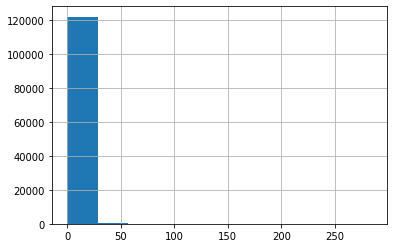

In [15]:
df_train['microbusiness_density'].hist()

In [16]:
df_train['microbusiness_density'].describe()

count    122265.000000
mean          3.817671
std           4.991087
min           0.000000
25%           1.639344
50%           2.586543
75%           4.519231
max         284.340030
Name: microbusiness_density, dtype: float64

<AxesSubplot:>

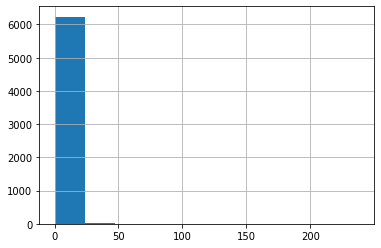

In [17]:
df_revealed['microbusiness_density'].hist()

In [18]:
df_train.groupby('region')['region'].count()

region
Far West           7098
Great Lakes       17043
Mideast            6942
New England        2613
Plains            24024
Rocky Mountain     8424
Southeast         41340
Southwest         14781
Name: region, dtype: int64

In [19]:
df_revealed.groupby('region')['region'].count()

region
Far West           364
Great Lakes        874
Mideast            356
New England        134
Plains            1232
Rocky Mountain     432
Southeast         2120
Southwest          758
Name: region, dtype: int64

In [20]:
df_all_train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,region
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,Southeast
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,Southeast
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,Southeast
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,Southeast
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,Southeast
...,...,...,...,...,...,...,...,...
6265,56041_2022-12-01,56041,Uinta County,Wyoming,2022-12-01,4.050703,588,Rocky Mountain
6266,56043_2022-11-01,56043,Washakie County,Wyoming,2022-11-01,3.143093,190,Rocky Mountain
6267,56043_2022-12-01,56043,Washakie County,Wyoming,2022-12-01,3.060380,185,Rocky Mountain
6268,56045_2022-11-01,56045,Weston County,Wyoming,2022-11-01,1.785395,100,Rocky Mountain


### Reduce train data to speed up model evaluation 

In [21]:
my_seed=55

In [22]:
REDUCE_SAMPLE=True

In [23]:
if  REDUCE_SAMPLE:    
    all_cfips=df_all_train[df_all_train['active']>10].cfips.unique()
    np.random.seed(my_seed)
    np.random.shuffle(all_cfips)
    reduced_cfips=all_cfips[:250]
    df_train=df_all_train[df_all_train['cfips'].isin(reduced_cfips)]
    df_train
else:
    df_train=df_all_train
df_train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,region
663,1035_2019-08-01,1035,Conecuh County,Alabama,2019-08-01,0.739241,73,Southeast
664,1035_2019-09-01,1035,Conecuh County,Alabama,2019-09-01,0.729114,72,Southeast
665,1035_2019-10-01,1035,Conecuh County,Alabama,2019-10-01,0.739241,73,Southeast
666,1035_2019-11-01,1035,Conecuh County,Alabama,2019-11-01,0.769620,76,Southeast
667,1035_2019-12-01,1035,Conecuh County,Alabama,2019-12-01,0.759494,75,Southeast
...,...,...,...,...,...,...,...,...
6213,55131_2022-12-01,55131,Washington County,Wisconsin,2022-12-01,6.380485,6751,Great Lakes
6256,56033_2022-11-01,56033,Sheridan County,Wyoming,2022-11-01,227.693980,54494,Rocky Mountain
6257,56033_2022-12-01,56033,Sheridan County,Wyoming,2022-12-01,238.060420,56975,Rocky Mountain
6262,56039_2022-11-01,56039,Teton County,Wyoming,2022-11-01,26.372364,5054,Rocky Mountain


In [24]:
all_cfips=df_train.cfips.unique()
train_cfips=all_cfips

In [25]:
df_train_set=df_train[df_train['cfips'].isin(train_cfips)]

In [26]:
df_train['cfips'].nunique()

250

In [27]:
df_train_set['cfips'].nunique()

250

# PreProcessing

In [28]:
base_num_features=["pct_bb","pct_college","pct_foreign_born","pct_it_workers","median_hh_inc",'population','active']

In [29]:
class GeoLocationTransformer(TransformerMixin, BaseEstimator):        
        
    def fit(self, x, y=None):    
        return self      

    def transform(self, df, y=None):
        self.feature_names=['row_id','first_day_of_month','microbusiness_density','state', 'county' ,'active','is_predicted_data']    
        
        print(f'starting ge loc feature with input shape:  {df.shape}')        
        df = df.merge(df_geo_loc, on='cfips')   
        self.feature_names.extend(df_geo_loc.columns.values)   
        
        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names    

In [30]:
class CensorEnricher(TransformerMixin, BaseEstimator):        
        
    def fit(self, x, y=None):    
        return self   

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)     
                        
        print(f'starting censor feature with input shape:  {df.shape}')        
        df = df.merge(df_census, on='cfips')                     
        self.feature_names.extend(df_census.columns.values)                
        self.feature_names=set(self.feature_names)
        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names    

In [31]:
class TimeSeriesTransformer(TransformerMixin, BaseEstimator):        
        
    def fit(self, x, y=None):    
        return self   

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)     
        
        print(f'starting TS feature with input shape:  {df.shape} ')        
        
        df['first_day_of_month'] = pd.to_datetime(df["first_day_of_month"])
        df["year"] = df["first_day_of_month"].dt.year
        df['month'] = df["first_day_of_month"].dt.month
        
        self.feature_names.extend(['year','month'])    
        conditions = [df['year']==2019,df['year']==2020,df['year']==2021, df['year']==2022, df['year']==2023]
        features=base_num_features
        cols_to_delete=[]
        for feature in features:
            if feature == 'active':
                continue
            wanted_cols=[c  for c in df.columns if feature in c]
            wanted_cols.sort()            
            cols_to_delete.extend(wanted_cols)
            choices=[ df[wc] for wc in wanted_cols ]            
            
            df[feature] = np.select(conditions, choices, default=np.nan)
            # remove redundant columns now 
            [ self.feature_names.remove(wc)  for wc in wanted_cols ]     
        
        self.feature_names.extend(features)                
       
        self.feature_names=set(self.feature_names)
        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names    

In [32]:
class StateAndCountyAvgTransformer(TransformerMixin, BaseEstimator):        
        
    def fit(self, df, y=None):    
        self.fed_mean=df.groupby(['first_day_of_month'])['microbusiness_density'].mean().to_frame().rename(columns={'microbusiness_density':'fed_microbusiness_density'})
        self.state_mean=df.groupby(['first_day_of_month', 'state'])['microbusiness_density'].mean().to_frame().rename(columns={'microbusiness_density':'state_microbusiness_density'})

        return self   

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)        
        
        print(f'starting state and county avg feature with input shape:  {df.shape}')        
                
        df=df.merge(self.fed_mean,on=['first_day_of_month'])
        df=df.merge(self.state_mean,on=['first_day_of_month','state'], how='left')
        df['state_microbusiness_density']= np.where(pd.isnull(df['state_microbusiness_density']), df['fed_microbusiness_density'], df['state_microbusiness_density'])
        
        self.feature_names.extend(['fed_microbusiness_density','state_microbusiness_density'])   
        
        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names    

In [33]:
class LagDiffAndRollingMeanTransformer(TransformerMixin, BaseEstimator):        
        
    @property
    def rolling_windows(self):
        return [2, 4, 6, 8]
    
    @property
    def lags(self):
        return 6
    
    def fit(self, df,  y=None):            
        return self   

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)        

        print(f'starting lag, diff, rolling mean feature with input shape:  {df.shape}')        
        df.sort_values(['cfips','first_day_of_month'], inplace=True)         
        df['microbusiness_density_T1']=df.groupby('cfips')['microbusiness_density'].shift(-1)
        self.feature_names.append('microbusiness_density_T1')   
        
        for lag in range(1, self.lags):
            #print(f"lag: {lag}")
            df[f'lag_mbd_{lag}']=df.groupby('cfips')['microbusiness_density'].shift(lag)
            df[f'lag_mbd_s_{lag}']=df.groupby('cfips')['microbusiness_density'].shift(lag+11)
            df[f'lag_diff_mbd_s_{lag}']=df.groupby('cfips')[f'lag_mbd_s_{lag}'].diff(lag)
            df[f'diff_mbd_{lag}']=df.groupby('cfips')['microbusiness_density'].diff(lag)
            df[f'diff_mbd_s_{lag}']=df.groupby('cfips')['microbusiness_density'].diff(lag+8)            
            df[f'diff_active_{lag}']=df.groupby('cfips')['active'].diff(lag)
            df[f'diff_population_{lag}']=df.groupby('cfips')['population'].diff(lag)
            
            
            self.feature_names.extend([f'lag_mbd_{lag}', f'lag_mbd_s_{lag}', f'diff_mbd_{lag}',
                                       f'diff_active_{lag}',f'diff_population_{lag}', f'diff_mbd_s_{lag}'])   
        
        for window in self.rolling_windows:                        
            df[f'roll_avg_{window}'] = df.groupby('cfips')[f'lag_mbd_1'].transform(lambda s: s.rolling(window, min_periods=1).mean())  
            df[f'roll_avg_D_{window}'] = df.groupby('cfips')[f'diff_mbd_1'].transform(lambda s: s.rolling(window, min_periods=1).mean())              
            self.feature_names.append(f'roll_avg_{window}')   
        
        #print(f"{self.feature_names}")        
        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names    

In [34]:
class RateTransformer(TransformerMixin, BaseEstimator):        
        
    def fit(self, df, y=None):    
        return self   

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)        
        
        print(f'starting rate feature with input shape:  {df.shape}')        
        
        df.sort_values(['cfips','first_day_of_month'], inplace=True)                   
        df['rate_mbd']=df.groupby('cfips')['microbusiness_density'].shift(1)
        df['rate_mbd'] = df['rate_mbd']/df['microbusiness_density'] - 1                        
        self.feature_names.append('rate_mbd')   
        
        for n in base_num_features:
            col_name=f'rate_{n}'
            df[col_name]=df.groupby('cfips')[n].shift(1)
            df[col_name] = df[col_name]/df[n] - 1  
            self.feature_names.append(col_name)   
        
        #df['mbd_S_1']=df.groupby('cfips')['microbusiness_density'].shift(1)
        #df['mbd_D_1']=df.groupby('cfips')['microbusiness_density'].shift(1).diff()
        #self.feature_names.extend(['mbd_S_1','mbd_D_1'])               
        
        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names    

In [35]:
class FillNAImputer(TransformerMixin, BaseEstimator):        
        
    def fit(self, x, y=None):    
        return self   

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)     
                                    
        print(f'starting fill na imputer with input shape:  {df.shape}')        
            
        
        df.sort_values(['cfips','first_day_of_month'], inplace=True) 
        rate_cols=[c for c in df.columns if "rate_" in c]
        lag_cols=[c for c in df.columns if "lag_" in c]
        diff_cols=[c for c in df.columns if "diff_" in c]
        roll_cols=[c for c in df.columns if "roll_" in c]
        enriched_cols=rate_cols+ lag_cols+ diff_cols + roll_cols 
        cols=base_num_features+enriched_cols
        
        # first fill zero values with NA         
        #df[cols]=df[cols].mask(df[cols]==0,np.nan)        
        df[cols]=df.groupby('cfips')[cols].fillna(method='ffill')
                
        for c in enriched_cols:
            #print(f'Filling na enriched column:{c}')
            df[c]=df.groupby('cfips')[c].fillna(method='bfill')            
        
        df[cols]=df[cols].mask(pd.isnull(df[cols]),0)        
        df[cols]=df[cols].mask(~np.isfinite(df[cols]),0)  
                
        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names  

In [36]:
class FeatureSelector(TransformerMixin, BaseEstimator):        
    
    def __init__(self, all_features):
        self.all_features=all_features
        
    def fit(self, x, y=None):    
        return self   

    def transform(self, df, y=None):
        print(f'starting feature selector  with input shape:  {df.shape}')
        return  df[self.all_features]
    
    def get_feature_names(self):
        return self.feature_names  

In [37]:
rate_cols=["rate_mbd"]+[f'rate_{c}' for c in base_num_features ] 
num_features=['state_latitude', 'state_longitude', 'county_latitude', 'county_longitude']+ base_num_features
#num_features=base_num_features
lags_diff_rolls=['lag_mbd_1', 'lag_mbd_s_1', 'diff_mbd_1', 'diff_active_1', 'diff_population_1', 
                 'diff_mbd_s_1', 'lag_mbd_2', 'lag_mbd_s_2', 'diff_mbd_2', 'diff_active_2', 'diff_population_2',
                 'diff_mbd_s_2', 'lag_mbd_3', 'lag_mbd_s_3', 'diff_mbd_3', 'diff_active_3', 'diff_population_3', 
                 'diff_mbd_s_3', 'lag_mbd_4', 'lag_mbd_s_4', 'diff_mbd_4', 'diff_active_4', 'diff_population_4',
                 'diff_mbd_s_4', 'lag_mbd_5', 'lag_mbd_s_5', 'diff_mbd_5', 'diff_active_5', 'diff_population_5',
                 'diff_mbd_s_5', 'roll_avg_2', 'roll_avg_4', 'roll_avg_6', 'roll_avg_8']
cat_features=['cfips']
final_features=['cfips','is_predicted_data','microbusiness_density','fed_microbusiness_density','state_microbusiness_density'] + num_features + rate_cols + lags_diff_rolls
target_feature=['microbusiness_density'] # ['microbusiness_density_T1']
all_features=['first_day_of_month'] + final_features
#all_features=['first_day_of_month'] + final_features+target_feature
final_features

['cfips',
 'is_predicted_data',
 'microbusiness_density',
 'fed_microbusiness_density',
 'state_microbusiness_density',
 'state_latitude',
 'state_longitude',
 'county_latitude',
 'county_longitude',
 'pct_bb',
 'pct_college',
 'pct_foreign_born',
 'pct_it_workers',
 'median_hh_inc',
 'population',
 'active',
 'rate_mbd',
 'rate_pct_bb',
 'rate_pct_college',
 'rate_pct_foreign_born',
 'rate_pct_it_workers',
 'rate_median_hh_inc',
 'rate_population',
 'rate_active',
 'lag_mbd_1',
 'lag_mbd_s_1',
 'diff_mbd_1',
 'diff_active_1',
 'diff_population_1',
 'diff_mbd_s_1',
 'lag_mbd_2',
 'lag_mbd_s_2',
 'diff_mbd_2',
 'diff_active_2',
 'diff_population_2',
 'diff_mbd_s_2',
 'lag_mbd_3',
 'lag_mbd_s_3',
 'diff_mbd_3',
 'diff_active_3',
 'diff_population_3',
 'diff_mbd_s_3',
 'lag_mbd_4',
 'lag_mbd_s_4',
 'diff_mbd_4',
 'diff_active_4',
 'diff_population_4',
 'diff_mbd_s_4',
 'lag_mbd_5',
 'lag_mbd_s_5',
 'diff_mbd_5',
 'diff_active_5',
 'diff_population_5',
 'diff_mbd_s_5',
 'roll_avg_2',
 'rol

In [38]:
def createPreprocessing():
    preprocessing=make_pipeline(GeoLocationTransformer(), 
                            CensorEnricher(),                            
                            TimeSeriesTransformer(),
                            StateAndCountyAvgTransformer(),
                            RateTransformer(),
                            LagDiffAndRollingMeanTransformer(),
                            FillNAImputer(), 
                            FeatureSelector(all_features),
                            verbose=True)
    return preprocessing

In [39]:
preprocessing=createPreprocessing()
#minMaxScalar=MinMaxScaler()
df_train_set['is_predicted_data']=0
df_train_processed=preprocessing.fit_transform(df_train_set)
#df_train_processed[final_features]=minMaxScalar.fit_transform(df_train_processed[final_features])

df_valid_processed = None

starting ge loc feature with input shape:  (10250, 9)
[Pipeline]  (step 1 of 8) Processing geolocationtransformer, total=   0.0s
starting censor feature with input shape:  (10250, 12)
[Pipeline] .... (step 2 of 8) Processing censorenricher, total=   0.0s
starting TS feature with input shape:  (10250, 42) 
[Pipeline]  (step 3 of 8) Processing timeseriestransformer, total=   0.0s
starting state and county avg feature with input shape:  (10250, 20)
[Pipeline]  (step 4 of 8) Processing stateandcountyavgtransformer, total=   0.0s
starting rate feature with input shape:  (10250, 22)
[Pipeline] ... (step 5 of 8) Processing ratetransformer, total=   0.0s
starting lag, diff, rolling mean feature with input shape:  (10250, 30)
[Pipeline]  (step 6 of 8) Processing lagdiffandrollingmeantransformer, total=   1.7s
starting fill na imputer with input shape:  (10250, 65)
[Pipeline] ..... (step 7 of 8) Processing fillnaimputer, total=   2.3s
starting feature selector  with input shape:  (10250, 65)
[Pi

In [40]:
pd.isnull(df_train_processed).sum(axis=0).sum()

0

In [41]:
(~np.isfinite(df_train_processed[final_features])).sum(axis=0).sum()

0

In [42]:
df_train_processed.reset_index()[all_features]

,first_day_of_month,cfips,is_predicted_data,microbusiness_density,fed_microbusiness_density,state_microbusiness_density,state_latitude,state_longitude,county_latitude,county_longitude,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc,population,active,rate_mbd,rate_pct_bb,rate_pct_college,rate_pct_foreign_born,rate_pct_it_workers,rate_median_hh_inc,rate_population,rate_active,lag_mbd_1,lag_mbd_s_1,diff_mbd_1,diff_active_1,diff_population_1,diff_mbd_s_1,lag_mbd_2,lag_mbd_s_2,diff_mbd_2,diff_active_2,diff_population_2,diff_mbd_s_2,lag_mbd_3,lag_mbd_s_3,diff_mbd_3,diff_active_3,diff_population_3,diff_mbd_s_3,lag_mbd_4,lag_mbd_s_4,diff_mbd_4,diff_active_4,diff_population_4,diff_mbd_s_4,lag_mbd_5,lag_mbd_s_5,diff_mbd_5,diff_active_5,diff_population_5,diff_mbd_s_5,roll_avg_2,roll_avg_4,roll_avg_6,roll_avg_8
0,2019-08-01,1035,0,0.739241,4.138585,3.524903,32.318231,-86.902298,31.430926,-86.988722,40.7,5.2,0.8,2.8,30434.0,9875.0,73,0.013889,0.0,0.0,0.0,0.0,0.0,0.0,0.013889,0.739241,0.739241,-0.010127,-1.0,0.0,0.011038,0.739241,0.739241,0.000000,0.0,0.0,0.051594,0.739241,0.739241,0.030380,3.0,0.0,0.051594,0.739241,0.739241,0.020253,2.0,0.0,0.051594,0.739241,0.739241,0.051594,5.0,-12.0,0.051594,0.739241,0.739241,0.739241,0.739241
1,2019-09-01,1035,0,0.729114,4.135809,3.528114,32.318231,-86.902298,31.430926,-86.988722,40.7,5.2,0.8,2.8,30434.0,9875.0,72,0.013889,0.0,0.0,0.0,0.0,0.0,0.0,0.013889,0.739241,0.739241,-0.010127,-1.0,0.0,0.011038,0.739241,0.739241,0.000000,0.0,0.0,0.051594,0.739241,0.739241,0.030380,3.0,0.0,0.051594,0.739241,0.739241,0.020253,2.0,0.0,0.051594,0.739241,0.739241,0.051594,5.0,-12.0,0.051594,0.739241,0.739241,0.739241,0.739241
2,2019-10-01,1035,0,0.739241,4.129840,3.526904,32.318231,-86.902298,31.430926,-86.988722,40.7,5.2,0.8,2.8,30434.0,9875.0,73,-0.013699,0.0,0.0,0.0,0.0,0.0,0.0,-0.013699,0.729114,0.739241,0.010127,1.0,0.0,0.011038,0.739241,0.739241,0.000000,0.0,0.0,0.051594,0.739241,0.739241,0.030380,3.0,0.0,0.051594,0.739241,0.739241,0.020253,2.0,0.0,0.051594,0.739241,0.739241,0.051594,5.0,-12.0,0.051594,0.734177,0.734177,0.734177,0.734177
3,2019-11-01,1035,0,0.769620,4.162735,3.573849,32.318231,-86.902298,31.430926,-86.988722,40.7,5.2,0.8,2.8,30434.0,9875.0,76,-0.039474,0.0,0.0,0.0,0.0,0.0,0.0,-0.039474,0.739241,0.739241,0.030380,3.0,0.0,0.011038,0.729114,0.739241,0.040506,4.0,0.0,0.051594,0.739241,0.739241,0.030380,3.0,0.0,0.051594,0.739241,0.739241,0.020253,2.0,0.0,0.051594,0.739241,0.739241,0.051594,5.0,-12.0,0.051594,0.734177,0.735865,0.735865,0.735865
4,2019-12-01,1035,0,0.759494,4.147996,3.563771,32.318231,-86.902298,31.430926,-86.988722,40.7,5.2,0.8,2.8,30434.0,9875.0,75,0.013333,0.0,0.0,0.0,0.0,0.0,0.0,0.013333,0.769620,0.739241,-0.010127,-1.0,0.0,0.011038,0.739241,0.739241,0.020253,2.0,0.0,0.051594,0.729114,0.739241,0.030380,3.0,0.0,0.051594,0.739241,0.739241,0.020253,2.0,0.0,0.051594,0.739241,0.739241,0.051594,5.0,-12.0,0.051594,0.754430,0.744304,0.744304,0.744304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10245,2022-08-01,56039,0,26.085369,4.537235,69.763530,43.075968,-107.290284,44.048662,-110.426087,89.1,37.2,11.4,1.5,87053.0,19164.0,4999,-0.005601,0.0,0.0,0.0,0.0,0.0,0.0,-0.005601,25.939260,25.719137,0.146109,28.0,0.0,0.419304,25.652266,25.602377,0.433103,83.0,0.0,0.456455,25.506157,25.655451,0.579212,111.0,0.0,0.567907,25.626175,25.591763,0.459194,88.0,0.0,0.366232,25.636610,25.581148,0.448759,86.0,0.0,0.482992,25.795763,25.680965,25.633132,25.647194
10246,2022-09-01,56039,0,26.090586,4.612613,77.176413,43.075968,-107.290284,44.048662,-110.426087,89.1,37.2,11.4,1.5,87053.0,19164.0,5000,-0.000200,0.0,0.0,0.0,0.0,0.0,0.0,-0.000200,26.085369,25.517462,0.005217,1.0,0.0,0.244072,25.939260,25.719137,0.151326,29.0,0.0,0.424521,25.652266,25.602377,0.438320,84.0,0.0,0.461672,25.506157,25.655451,0.

In [43]:
df_train_processed.shape

(10250, 59)

In [44]:
def smape0(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

In [45]:
def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap

In [46]:
def get_model(max_iter=2000):
    import catboost as cat    
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import Ridge, Lasso
    import lightgbm as lgb
    from sklearn.ensemble import StackingRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import VotingRegressor
    from sklearn.ensemble import ExtraTreesRegressor
    from sklearn.linear_model import OrthogonalMatchingPursuit
    

    ridge_model=Ridge(alpha=1,random_state=my_seed)    
    lasso_model= Lasso(alpha=1,random_state=my_seed)
    et= ExtraTreesRegressor(n_estimators=max_iter, 
                            criterion='squared_error',                            
                            #min_samples_leaf=5,
                            verbose=1,
                            n_jobs=-1,
                            random_state=my_seed)
    rt=RandomForestRegressor(n_estimators=500, random_state=my_seed)    
    omh=OrthogonalMatchingPursuit()
        
    cat_model = cat.CatBoostRegressor(       
        iterations=max_iter,
        loss_function="RMSE",
        #max_depth=7,        
        #learning_rate=0.0368283,
        #l2_leaf_reg=4.2985155,
        #rsm= 0.5,
        #subsample=0.7,
        #border_count=254,
        #learning_rate=0.01,  
        #border_count=254,
        #colsample_bylevel=0.8,
        #max_depth=5,
        #l2_leaf_reg=0.2,
        #subsample=0.70,
        #max_bin=4096,
        verbose=max(1,int(max_iter/10)),
        random_state=my_seed)    
    
    params = {
        'force_col_wise':True, # memory foot print is smaller
        'verbose':0,
        'num_iterations':max_iter,
        'objective': 'rmse',
        'metric': "mape",
        'boosting': 'dart',        
        #'max_depth' : 8,
        'seed': my_seed,        
        #'learning_rate': 0.01,
        #'num_leaves':  2 ** 11, 
        'min_data_in_leaf': 1,
        'num_threads': -1,
        #'subsample': 0.9,  
        #'subsample_freq': 1,
        #'first_metric_only': True,
        #'boost_from_average': False,
        #'tree_learner': 'serial',       
        #'eval_metric':['mape','rmse'],
        # max(1,max_iter//10),
    }    

    lgb_model = lgb.LGBMRegressor(**params)
    
    #return lgb_model
    #return VotingRegressor([('l2',ridge_model),('et',et),('omh',omh), ('lgb',lgb_model)])        
    #return VotingRegressor([('l2',ridge_model),('lgb',lgb_model)],weights=[0.5,0.5])    
    #return VotingRegressor([('lgb',lgb_model)],weights=[1])    
    #return VotingRegressor([('l1',lasso_model),('et',et),('omh',omh), ('rt',rt),('cat_model',cat_model)])    # 3.14
    #return VotingRegressor([('l2',ridge_model),('et',et),('omh',omh), ('rt',rt),('cat_model',cat_model)],n_jobs=-1, verbose=True)    # 3.14
    #return VotingRegressor([('l2',ridge_model),('et',et),('omh',omh), ('rt',rt),('cat_model',cat_model)],n_jobs=-1, verbose=True)    # 3.14
    #return VotingRegressor([('et',et),('rt',rt)],n_jobs=-1, verbose=True)    # 3.14
    #return ridge_model
    #return lasso_model
    #return cat_model    
    return et
    #return StackingRegressor([('l2',ridge_model),('et',et),('omh',omh), ('rt',rt),('cat_model',cat_model)],n_jobs=-1,verbose=1)    # 3.14

    

In [47]:
ACT_THR =150
ABS_THR =0.00

In [48]:
def get_outlier_idx(df, act_thr=None, abs_thr=None):
    if act_thr is None:
        act_thr=ACT_THR

    if abs_thr  is None:
        abs_thr=ABS_THR
    idx=(df.active<act_thr) & df.microbusiness_density<abs_thr  #|  (df['cfips'].isin(outliers_cfips))
    return idx        

In [49]:
def train_model(model, df_train0, target_label, max_iter=1000,  act_thr=None, abs_thr=None):  
    
    idx=get_outlier_idx(df_train0,act_thr, abs_thr)
    df=df_train0[~idx]
    target_label0=target_label[~idx.values]
    
    """
    params={'lgb__verbose': max(1,max_iter//10),
            'lgb__eval_metric':['mape','rmse']
           }
    model.set_params(**params)
    """
    model.fit(df[final_features],target_label0, )    # L2    
    #model.fit(df[final_features],target_label0, cat_features=['cfips'])
    
    """
    # lgb
    model.fit(df[final_features],target_label0, categorical_feature=['cfips'],
              eval_set=[(df[final_features],target_label0)], 
              verbose = max(1,max_iter//10),eval_metric=['mape','rmse'])
    """    
    return df.shape

In [50]:
def predict_model(model, df_test0, act_thr=None, abs_thr=None, multiplier=1):  
    idx=get_outlier_idx(df_test0, act_thr, abs_thr)
    y_pred = model.predict(df_test0[final_features])     #R2
    y_pred=np.where(idx, df_test0['microbusiness_density'],y_pred)    
    return y_pred*multiplier

In [51]:
max_iter=100
is_validation=True

#valid_dates1=['2022-12-01']
valid_dates1=['2022-10-01','2022-11-01','2022-12-01']
valid_dates2=['2023-01-01','2023-02-01','2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01']
valid_dates = valid_dates1 if is_validation  else valid_dates2

results={}
np.random.seed(my_seed)
cfips_set=df_train_set['cfips'].unique()
row_ids=[f'{c}_{d.strftime("%Y-%m-%d")}' for c,d in itertools.product(cfips_set,pd.to_datetime(valid_dates))]
df_submission= pd.DataFrame({'row_id':row_ids,target_feature[0]:np.zeros(len(row_ids))})
df_submission.set_index('row_id', inplace=True)
df_res=None
df_raw_train0=None
df_first_pred=None
model = get_model(max_iter)    
for j, v_date in enumerate(pd.to_datetime(valid_dates)):    
    last_train_date=pd.to_datetime(v_date)-relativedelta(months=2)
    previous_date=pd.to_datetime(v_date)-relativedelta(months=1)   
        
    preprocessing=createPreprocessing()    
    
    if df_raw_train0 is None:
        df_raw_train0=df_train_set[df_train_set['first_day_of_month']<=last_train_date]     
        df_raw_train0_label=df_train_set[df_train_set['first_day_of_month']<v_date] 
    else :
        #df_raw_train0=df_train_set[df_train_set['first_day_of_month']<last_train_date]     
        df_raw_train0_label=df_raw_train0[df_raw_train0['first_day_of_month']<v_date]
        df_raw_train0=df_raw_train0[df_raw_train0['first_day_of_month']<=last_train_date]     
            
    print(f"{j} last_date:{last_train_date} v_date:{v_date} df_raw_train0: {df_raw_train0.shape}")
        
    if is_validation:
        df_valid1=df_train_set[df_train_set['first_day_of_month']==v_date]
        df_valid0=df_valid1.copy().set_index('cfips')    
        df_valid1['row_id']=df_valid1.apply(lambda r:"{}_{}".format(r.cfips,r.first_day_of_month.strftime("%Y-%m-%d")), axis=1)    
        df_valid1.set_index('row_id', inplace=True)
        if df_res is None:
            df_res=df_valid0[target_feature].copy()            
            df_res['active']=df_valid0['active'].copy()                        
            df_res.rename(columns={'y_true_0':target_feature})
        
    print(f'==== {j} Train preprocessing')
    df_train0=preprocessing.fit_transform(df_raw_train0)    
    print(f'==== {j} Validation preprocessing')
    df_train0_label=preprocessing.fit_transform(df_raw_train0_label)    
    
    df_raw_test0=df_raw_train0_label[df_raw_train0_label['first_day_of_month']==previous_date]   
    df_test0=df_train0_label[df_train0_label['first_day_of_month']==previous_date]   
        
    print(f" df_test0: {df_test0.shape} df_train0: {df_train0.shape} ")    
    
    df_raw_train0_label.sort_values(['cfips','first_day_of_month'], inplace=True)      
    target_label=df_raw_train0_label.groupby('cfips')['microbusiness_density'].shift(-1)
    target_label.dropna(inplace=True)        
    model = get_model(max_iter)    
    train_model(model,df_train0,target_label, max_iter )
        
    y_pred = predict_model(model,df_test0)              
   
    if not is_validation and v_date<dt.date(2023,1,1):  ## XXXXX
        df_valid1=df_train_set[df_train_set['first_day_of_month']==v_date]
        df_valid1.set_index('row_id', inplace=True)
        #y_pred=df_valid1['microbusiness_density'].values                    
    
    test_row_ids=[f'{c}_{d.strftime("%Y-%m-%d")}' for c,d in itertools.product(df_test0.cfips.values,[v_date])]
    df_submission.loc[test_row_ids,target_feature[0]]=y_pred
        
    if is_validation:        
        y_pred_train = predict_model(model,df_train0)  
        metrics_train=smape0(target_label,y_pred_train)

        df_test0_label=df_valid1[df_valid1['first_day_of_month']==v_date] 
        print(f" df_test0: {df_test0.shape} df_test0_label.shape: {df_test0_label.shape} df_train0: {df_train0.shape} ")

        metrics=smape0(df_test0_label[target_feature].values[:,0],y_pred)        
        print(f'{j} SMAPE Valid: {metrics} metrics_train :{metrics_train} date: {v_date} len: {len(y_pred)}') 
        results[v_date]=metrics
    
        df_res[f'y_pred_{j}']=y_pred
        df_res[f'y_true_{j}']=df_valid0[target_feature]
        df_res[f'err_{j}']=df_res[f'y_true_{j}']-df_res[f'y_pred_{j}']
        df_res[f'vsmape_{j}']=vsmape(df_valid0[target_feature].values[:,0],y_pred)
        df_res[f'vsmape_{j}']=vsmape(df_valid0[target_feature].values[:,0],y_pred)        
        df_submission.loc[test_row_ids,f'{target_feature[0]}_true']=df_valid1.loc[test_row_ids,target_feature[0]]
        
    df_tmp=df_raw_test0.copy()[df_raw_train0.columns]
    print(f"df_tmp: {df_tmp.shape} y_pred: {y_pred.shape}")
    df_tmp['first_day_of_month']=v_date
    df_tmp['microbusiness_density']=y_pred    
    df_tmp['row_id']=df_tmp.apply(lambda r: f'{r.cfips}_{r.first_day_of_month.strftime("%Y-%m-%d")}'  , axis=1)
    df_tmp['is_predicted_data']=1
    df_raw_train0=pd.concat([df_raw_train0,df_raw_test0,df_tmp])    
        
    
print(results)
    

0 last_date:2022-08-01 00:00:00 v_date:2022-10-01 00:00:00 df_raw_train0: (9250, 9)
==== 0 Train preprocessing
starting ge loc feature with input shape:  (9250, 9)
[Pipeline]  (step 1 of 8) Processing geolocationtransformer, total=   0.0s
starting censor feature with input shape:  (9250, 12)
[Pipeline] .... (step 2 of 8) Processing censorenricher, total=   0.0s
starting TS feature with input shape:  (9250, 42) 
[Pipeline]  (step 3 of 8) Processing timeseriestransformer, total=   0.0s
starting state and county avg feature with input shape:  (9250, 20)
[Pipeline]  (step 4 of 8) Processing stateandcountyavgtransformer, total=   0.0s
starting rate feature with input shape:  (9250, 22)
[Pipeline] ... (step 5 of 8) Processing ratetransformer, total=   0.0s
starting lag, diff, rolling mean feature with input shape:  (9250, 30)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[Pipeline]  (step 6 of 8) Processing lagdiffandrollingmeantransformer, total=   1.6s
starting fill na imputer with input shape:  (9250, 65)
[Pipeline] ..... (step 7 of 8) Processing fillnaimputer, total=   2.3s
starting feature selector  with input shape:  (9250, 65)
[Pipeline] ... (step 8 of 8) Processing featureselector, total=   0.0s
==== 0 Validation preprocessing
starting ge loc feature with input shape:  (9500, 9)
[Pipeline]  (step 1 of 8) Processing geolocationtransformer, total=   0.0s
starting censor feature with input shape:  (9500, 12)
[Pipeline] .... (step 2 of 8) Processing censorenricher, total=   0.0s
starting TS feature with input shape:  (9500, 42) 
[Pipeline]  (step 3 of 8) Processing timeseriestransformer, total=   0.0s
starting state and county avg feature with input shape:  (9500, 20)
[Pipeline]  (step 4 of 8) Processing stateandcountyavgtransformer, total=   0.0s
starting rate feature with input shape:  (9500, 22)
[Pipeline] ... (step 5 of 8) Processing ratetransf

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
/opt/conda/lib/python3.7/site-p

 df_test0: (250, 59) df_test0_label.shape: (250, 8) df_train0: (9250, 59) 
0 SMAPE Valid: 1.4945999732449473 metrics_train :1.1787211301271997e-13 date: 2022-10-01 00:00:00 len: 250
df_tmp: (250, 9) y_pred: (250,)
1 last_date:2022-09-01 00:00:00 v_date:2022-11-01 00:00:00 df_raw_train0: (9500, 9)
==== 1 Train preprocessing
starting ge loc feature with input shape:  (9500, 9)
[Pipeline]  (step 1 of 8) Processing geolocationtransformer, total=   0.0s
starting censor feature with input shape:  (9500, 12)
[Pipeline] .... (step 2 of 8) Processing censorenricher, total=   0.0s
starting TS feature with input shape:  (9500, 42) 
[Pipeline]  (step 3 of 8) Processing timeseriestransformer, total=   0.0s
starting state and county avg feature with input shape:  (9500, 20)
[Pipeline]  (step 4 of 8) Processing stateandcountyavgtransformer, total=   0.0s
starting rate feature with input shape:  (9500, 22)
[Pipeline] ... (step 5 of 8) Processing ratetransformer, total=   0.0s
starting lag, diff, rolli

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 df_test0: (250, 59) df_test0_label.shape: (250, 8) df_train0: (9500, 59) 
1 SMAPE Valid: 2.23721417015336 metrics_train :1.1798071582920408e-13 date: 2022-11-01 00:00:00 len: 250
df_tmp: (250, 9) y_pred: (250,)
2 last_date:2022-10-01 00:00:00 v_date:2022-12-01 00:00:00 df_raw_train0: (9750, 9)
==== 2 Train preprocessing
starting ge loc feature with input shape:  (9750, 9)
[Pipeline]  (step 1 of 8) Processing geolocationtransformer, total=   0.0s
starting censor feature with input shape:  (9750, 12)
[Pipeline] .... (step 2 of 8) Processing censorenricher, total=   0.0s
starting TS feature with input shape:  (9750, 42) 
[Pipeline]  (step 3 of 8) Processing timeseriestransformer, total=   0.3s
starting state and county avg feature with input shape:  (9750, 20)
[Pipeline]  (step 4 of 8) Processing stateandcountyavgtransformer, total=   0.0s
starting rate feature with input shape:  (9750, 22)
[Pipeline] ... (step 5 of 8) Processing ratetransformer, total=   0.0s
starting lag, diff, rolling

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


 df_test0: (250, 59) df_test0_label.shape: (250, 8) df_train0: (9750, 59) 
2 SMAPE Valid: 3.285964115498342 metrics_train :1.1790243230191918e-13 date: 2022-12-01 00:00:00 len: 250
df_tmp: (250, 9) y_pred: (250,)
{Timestamp('2022-10-01 00:00:00'): 1.4945999732449473, Timestamp('2022-11-01 00:00:00'): 2.23721417015336, Timestamp('2022-12-01 00:00:00'): 3.285964115498342}


In [52]:
if is_validation:
    valid_smape0=smape0(df_submission['microbusiness_density'].values,df_submission['microbusiness_density_true'].values)
    print(f"valid_smape0: {valid_smape0}")

valid_smape0: 2.3392594196322167


In [53]:
def  analyse_model(model,desc, raw_numer=10, plot=False):
    import seaborn as sns
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    print(desc)
    fi=pd.DataFrame({'Feature':final_features,'importance':model.feature_importances_})
    fi.sort_values('importance',ascending=False, inplace=True)

    if plot:
        ax=sns.barplot(y='Feature',x='importance',data=fi)
        plt.xticks(rotation=90)
    
    print(fi.head(raw_numer))
    return fi
#fi=analyse_model(model, "validation", plot=True)

# Prepare submission

In [54]:
df_all_train_nov_dec_2022=df_all_train[df_all_train['row_id'].apply(lambda x: '2022-11-01' in x or '2022-12-01' in x)][['row_id','microbusiness_density']]

In [55]:
df_submission1=df_submission.reset_index()[['row_id','microbusiness_density']]
df_submission1=pd.concat([df_all_train_nov_dec_2022,df_submission1]).sort_values('row_id')


df_submission1['cfips'] = df_submission1.row_id.apply(lambda x: int(x.split('_')[0]))
df_submission1['adj']=df_submission1.cfips.map(population_adjustment)

df_submission1.microbusiness_density= df_submission1.microbusiness_density*df_submission1.adj#*1.002
df_submission1 = df_submission1.drop(['adj','cfips'],axis=1)

df_submission1

,row_id,microbusiness_density
628,10001_2022-11-01,7.009184
629,10001_2022-12-01,7.064056
87,10003_2022-10-01,20.592279
630,10003_2022-11-01,20.598984
88,10003_2022-11-01,20.889754
...,...,...
84,9015_2022-10-01,3.579595
85,9015_2022-11-01,3.594347
626,9015_2022-11-01,3.578580
627,9015_2022-12-01,3.581792


In [56]:
current_time =dt.datetime.now().strftime("%y_%m_%d_%H_%M_%S")
df_submission1.to_csv(f'submission_{current_time}.csv', index=False)

In [57]:
df_submission1.shape

(7020, 2)

In [58]:
df_submission1.head(13)

,row_id,microbusiness_density
628,10001_2022-11-01,7.009184
629,10001_2022-12-01,7.064056
87,10003_2022-10-01,20.592279
630,10003_2022-11-01,20.598984
88,10003_2022-11-01,20.889754
89,10003_2022-12-01,21.310500
631,10003_2022-12-01,22.155528
632,10005_2022-11-01,59.977438
633,10005_2022-12-01,58.104307
0,1001_2022-11-01,3.292227


<AxesSubplot:>

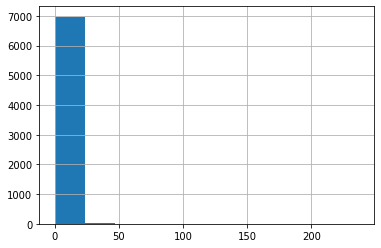

In [59]:
df_submission1.microbusiness_density.hist()

In [60]:
if is_validation:
    vsmape_cols=[c for c in df_res.columns if 'vsmape' in c ]
    df_res['vsmape']=df_res[vsmape_cols].mean(axis=1)

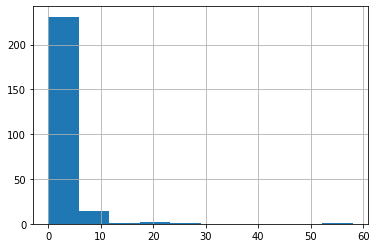

In [61]:
if is_validation:
    df_res['vsmape'].hist()

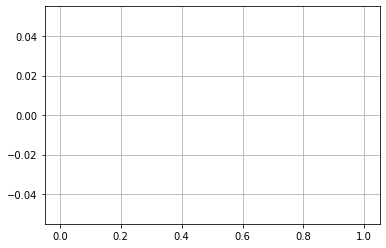

In [62]:
if is_validation:
    df_res[df_res.vsmape==5]['vsmape'].hist()

In [63]:
odd_cfips=[]
if is_validation:
    odd_cfips=df_res[df_res.vsmape>10].index #['cfips']
    df_train_set[df_train_set.cfips.isin(odd_cfips)]['active']
    df_train_set[df_train_set.cfips.isin(odd_cfips)]['active'].describe(percentiles=[0.75,0.9,0.95,0.975,0.99, 0.999])
odd_cfips

Int64Index([13131, 17135, 17151, 54053, 56033], dtype='int64', name='cfips')

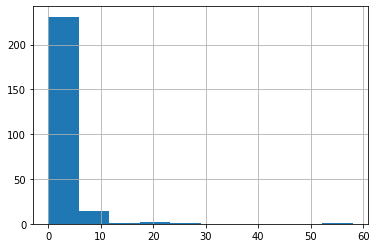

In [64]:
if is_validation:
    df_res.vsmape.hist()

odd_cfip:13131
odd_cfip:17135
odd_cfip:17151
odd_cfip:54053
odd_cfip:56033


,first_day_of_month,microbusiness_density,cfips,is_predicted_data,microbusiness_density,fed_microbusiness_density,state_microbusiness_density,state_latitude,state_longitude,county_latitude,county_longitude,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc,population,active,rate_mbd,rate_pct_bb,rate_pct_college,rate_pct_foreign_born,rate_pct_it_workers,rate_median_hh_inc,rate_population,rate_active,lag_mbd_1,lag_mbd_s_1,diff_mbd_1,diff_active_1,diff_population_1,diff_mbd_s_1,lag_mbd_2,lag_mbd_s_2,diff_mbd_2,diff_active_2,diff_population_2,diff_mbd_s_2,lag_mbd_3,lag_mbd_s_3,diff_mbd_3,diff_active_3,diff_population_3,diff_mbd_s_3,lag_mbd_4,lag_mbd_s_4,diff_mbd_4,diff_active_4,diff_population_4,diff_mbd_s_4,lag_mbd_5,lag_mbd_s_5,diff_mbd_5,diff_active_5,diff_population_5,diff_mbd_s_5,roll_avg_2,roll_avg_4,roll_avg_6,roll_avg_8
248,2019-08-01,30.183279,56033,0,30.183279,4.138585,28.308321,43.075968,-107.290284,44.781369,-106.881211,80.9,18.3,2.3,1.6,56455.0,23407.0,7065,-0.048228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.048228,30.183279,30.183279,1.529457,358.0,0.0,10.733557,30.183279,30.183279,1.807152,423.0,0.0,10.009291,30.183279,30.183279,2.593241,607.0,0.0,11.078650,30.183279,30.183279,2.623148,614.0,0.0,11.402441,30.183279,30.183279,2.664370,645.0,65.0,12.092623,30.183279,30.183279,30.183279,30.183279
498,2019-09-01,31.712736,56033,0,31.712736,4.135809,29.162296,43.075968,-107.290284,44.781369,-106.881211,80.9,18.3,2.3,1.6,56455.0,23407.0,7423,-0.048228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.048228,30.183279,30.183279,1.529457,358.0,0.0,10.733557,30.183279,30.183279,1.807152,423.0,0.0,10.009291,30.183279,30.183279,2.593241,607.0,0.0,11.078650,30.183279,30.183279,2.623148,614.0,0.0,11.402441,30.183279,30.183279,2.664370,645.0,65.0,12.092623,30.183279,30.183279,30.183279,30.183279
748,2019-10-01,31.990431,56033,0,31.990431,4.129840,29.363346,43.075968,-107.290284,44.781369,-106.881211,80.9,18.3,2.3,1.6,56455.0,23407.0,7488,-0.008681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.008681,31.712736,30.183279,0.277695,65.0,0.0,10.733557,30.183279,30.183279,1.807152,423.0,0.0,10.009291,30.183279,30.183279,2.593241,607.0,0.0,11.078650,30.183279,30.183279,2.623148,614.0,0.0,11.402441,30.183279,30.183279,2.664370,645.0,65.0,12.092623,30.948007,30.948007,30.948007,30.948007
998,2019-11-01,32.776520,56033,0,32.776520,4.162735,29.848342,43.075968,-107.290284,44.781369,-106.881211,80.9,18.3,2.3,1.6,56455.0,23407.0,7672,-0.023983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.023983,31.990431,30.183279,0.786089,184.0,0.0,10.733557,31.712736,30.183279,1.063784,249.0,0.0,10.009291,30.183279,30.183279,2.593241,607.0,0.0,11.078650,30.183279,30.183279,2.623148,614.0,0.0,11.402441,30.183279,30.183279,2.664370,645.0,65.0,12.092623,31.851584,31.295482,31.295482,31.295482
1248,2019-12-01,32.806427,56033,0,32.806427,4.147996,29.855182,43.075968,-107.290284,44.781369,-106.881211,80.9,18.3,2.3,1.6,56455.0,23407.0,7679,-0.000912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000912,32.776520,30.183279,0.029907,7.0,0.0,10.733557,31.990431,30.183279,0.815996,191.0,0.0,10.009291,31.712736,30.183279,1.093691,256.0,0.0,11.078650,30.183279,30.183279,2.623148,614.0,0.0,11.402441,30.183279,30.183279,2.664370,645.0,65.0,12.092623,32.383476,31.665741,31.665741,31.665741
1498,2020-01-01,32.847649,56033,0,32.847649,4.099277,29.766107,43.075968,-107.290284,44.781369,-106.881211,81.1,16.2,2.1,1.7,58521.0,23472.0,7710,-0.001255,-0.002466,0.129630,0.095238,-0.058824,-0.035304,-0.002769,-0.004021,32.806427,30.183279,0.041222,31.0,65.0,10.733557,32.776520,30.183279,0.071129,38.0,65.0,10.009291,31.990431,30.183279,0.857218,222.0,65.0,11.078650,31.712736,30.183279,1.134913,287.0,65.0,11.402441,30.183279,30.183279,2.664370,645.0,65.0,12.092623,32.791473,32.321528,31.893879,31.893879
1748,2020-02-01,32.246933,56033,0,32.246933,4.049952,29.492594,43.075968,-107.290284,44.781369,-106.881211,81.1,16.

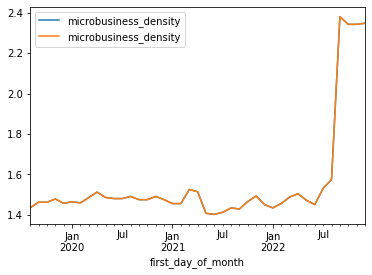

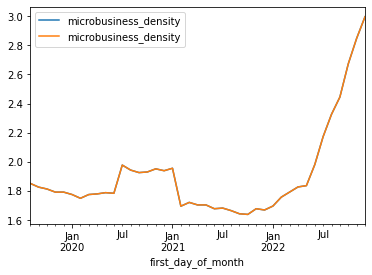

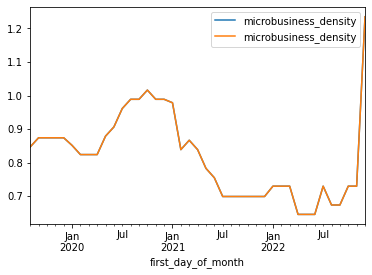

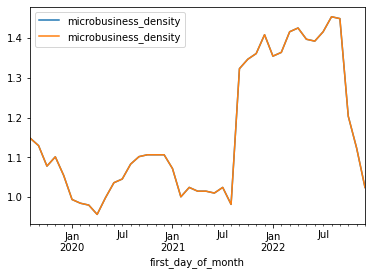

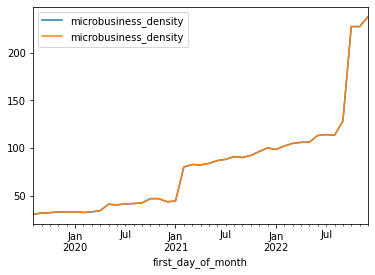

In [65]:
if is_validation:
    for odd_cfip in  odd_cfips:
        print(f"odd_cfip:{odd_cfip}")
        x=df_train0[df_train0.cfips==odd_cfip][['first_day_of_month']+target_feature+final_features]
        y=df_train_processed[df_train_processed.cfips==odd_cfip][['first_day_of_month']+target_feature+final_features]
        y.plot(x='first_day_of_month', y=target_feature)    
    display(x)

In [66]:
if is_validation:
    display(y)

,first_day_of_month,microbusiness_density,cfips,is_predicted_data,microbusiness_density,fed_microbusiness_density,state_microbusiness_density,state_latitude,state_longitude,county_latitude,county_longitude,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc,population,active,rate_mbd,rate_pct_bb,rate_pct_college,rate_pct_foreign_born,rate_pct_it_workers,rate_median_hh_inc,rate_population,rate_active,lag_mbd_1,lag_mbd_s_1,diff_mbd_1,diff_active_1,diff_population_1,diff_mbd_s_1,lag_mbd_2,lag_mbd_s_2,diff_mbd_2,diff_active_2,diff_population_2,diff_mbd_s_2,lag_mbd_3,lag_mbd_s_3,diff_mbd_3,diff_active_3,diff_population_3,diff_mbd_s_3,lag_mbd_4,lag_mbd_s_4,diff_mbd_4,diff_active_4,diff_population_4,diff_mbd_s_4,lag_mbd_5,lag_mbd_s_5,diff_mbd_5,diff_active_5,diff_population_5,diff_mbd_s_5,roll_avg_2,roll_avg_4,roll_avg_6,roll_avg_8
248,2019-08-01,30.183279,56033,0,30.183279,4.138585,28.308321,43.075968,-107.290284,44.781369,-106.881211,80.9,18.3,2.3,1.6,56455.0,23407.0,7065,-0.048228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.048228,30.183279,30.183279,1.529457,358.0,0.0,10.733557,30.183279,30.183279,1.807152,423.0,0.0,10.009291,30.183279,30.183279,2.593241,607.0,0.0,11.078650,30.183279,30.183279,2.623148,614.0,0.0,11.402441,30.183279,30.183279,2.664370,645.0,65.0,12.092623,30.183279,30.183279,30.183279,30.183279
498,2019-09-01,31.712736,56033,0,31.712736,4.135809,29.162296,43.075968,-107.290284,44.781369,-106.881211,80.9,18.3,2.3,1.6,56455.0,23407.0,7423,-0.048228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.048228,30.183279,30.183279,1.529457,358.0,0.0,10.733557,30.183279,30.183279,1.807152,423.0,0.0,10.009291,30.183279,30.183279,2.593241,607.0,0.0,11.078650,30.183279,30.183279,2.623148,614.0,0.0,11.402441,30.183279,30.183279,2.664370,645.0,65.0,12.092623,30.183279,30.183279,30.183279,30.183279
748,2019-10-01,31.990431,56033,0,31.990431,4.129840,29.363346,43.075968,-107.290284,44.781369,-106.881211,80.9,18.3,2.3,1.6,56455.0,23407.0,7488,-0.008681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.008681,31.712736,30.183279,0.277695,65.0,0.0,10.733557,30.183279,30.183279,1.807152,423.0,0.0,10.009291,30.183279,30.183279,2.593241,607.0,0.0,11.078650,30.183279,30.183279,2.623148,614.0,0.0,11.402441,30.183279,30.183279,2.664370,645.0,65.0,12.092623,30.948007,30.948007,30.948007,30.948007
998,2019-11-01,32.776520,56033,0,32.776520,4.162735,29.848342,43.075968,-107.290284,44.781369,-106.881211,80.9,18.3,2.3,1.6,56455.0,23407.0,7672,-0.023983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.023983,31.990431,30.183279,0.786089,184.0,0.0,10.733557,31.712736,30.183279,1.063784,249.0,0.0,10.009291,30.183279,30.183279,2.593241,607.0,0.0,11.078650,30.183279,30.183279,2.623148,614.0,0.0,11.402441,30.183279,30.183279,2.664370,645.0,65.0,12.092623,31.851584,31.295482,31.295482,31.295482
1248,2019-12-01,32.806427,56033,0,32.806427,4.147996,29.855182,43.075968,-107.290284,44.781369,-106.881211,80.9,18.3,2.3,1.6,56455.0,23407.0,7679,-0.000912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000912,32.776520,30.183279,0.029907,7.0,0.0,10.733557,31.990431,30.183279,0.815996,191.0,0.0,10.009291,31.712736,30.183279,1.093691,256.0,0.0,11.078650,30.183279,30.183279,2.623148,614.0,0.0,11.402441,30.183279,30.183279,2.664370,645.0,65.0,12.092623,32.383476,31.665741,31.665741,31.665741
1498,2020-01-01,32.847649,56033,0,32.847649,4.099277,29.766107,43.075968,-107.290284,44.781369,-106.881211,81.1,16.2,2.1,1.7,58521.0,23472.0,7710,-0.001255,-0.002466,0.129630,0.095238,-0.058824,-0.035304,-0.002769,-0.004021,32.806427,30.183279,0.041222,31.0,65.0,10.733557,32.776520,30.183279,0.071129,38.0,65.0,10.009291,31.990431,30.183279,0.857218,222.0,65.0,11.078650,31.712736,30.183279,1.134913,287.0,65.0,11.402441,30.183279,30.183279,2.664370,645.0,65.0,12.092623,32.791473,32.321528,31.893879,31.893879
1748,2020-02-01,32.246933,56033,0,32.246933,4.049952,29.492594,43.075968,-107.290284,44.781369,-106.881211,81.1,16.

# Best Model Search with pycaret

In [67]:
"""
!pip install --pre pycaret seaborn pandas-profiling -Uq
#import pycaret
#pycaret.__version__
from pycaret.regression import *
from pandas_profiling import ProfileReport
# show all columns
pd.set_option('display.max_columns', None)
"""

"\n!pip install --pre pycaret seaborn pandas-profiling -Uq\n#import pycaret\n#pycaret.__version__\nfrom pycaret.regression import *\nfrom pandas_profiling import ProfileReport\n# show all columns\npd.set_option('display.max_columns', None)\n"

In [68]:
#df=df_train_processed.reset_index()
#profile = ProfileReport(df[final_features], title="mbd")
#profile.to_notebook_iframe()

In [69]:
def smape_pycaret(y_true, y_pred, **kwargs):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)


In [70]:
#df_train0[final_features]
#df_train0['microbusiness_density_T1']=target_label.values

In [71]:
"""
idx=df_train0.active>ACT_THR    
df=df_train0[idx]
    
from pycaret.regression import *

s = setup(
    df[final_features+["microbusiness_density_T1"]],    
    test_data=df[final_features+["microbusiness_density_T1"]],
    #categorical_features=cat_features,
    preprocess=False,
    normalize=False,
    transformation=False,
    transform_target=False,
    #fold_strategy='groupkfold',
    #fold_groups='cfips',
    #remove_multicollinearity=True,
    #multicollinearity_threshold=0.95,
    target="microbusiness_density_T1",
    experiment_name="microbusiness_density",
)
s.add_metric('smap','SMAP',greater_is_better=False,score_func=smape_pycaret)
"""

'\nidx=df_train0.active>ACT_THR    \ndf=df_train0[idx]\n    \nfrom pycaret.regression import *\n\ns = setup(\n    df[final_features+["microbusiness_density_T1"]],    \n    test_data=df[final_features+["microbusiness_density_T1"]],\n    #categorical_features=cat_features,\n    preprocess=False,\n    normalize=False,\n    transformation=False,\n    transform_target=False,\n    #fold_strategy=\'groupkfold\',\n    #fold_groups=\'cfips\',\n    #remove_multicollinearity=True,\n    #multicollinearity_threshold=0.95,\n    target="microbusiness_density_T1",\n    experiment_name="microbusiness_density",\n)\ns.add_metric(\'smap\',\'SMAP\',greater_is_better=False,score_func=smape_pycaret)\n'

In [72]:
#best_model_count=10
#best_model=compare_models(exclude=['lar','catboost','rf'], n_select=best_model_count, sort='SMAP')

In [73]:
#for i in range(best_model_count):    
#    print(f"{i}: {best_model[i].__class__} {best_model[i].get_params()}")

'\nfor i in range(best_model_count):    \n    print(f"{i}: {best_model[i].__class__} {best_model[i].get_params()}")\n'

In [74]:
#plot_model(best_model, plot = 'feature')

In [75]:
#best_model.get_params()

In [76]:
#best_model